#### NOVA IMS / BSc in Data Science / Text Mining 2024/2025
### <b>Group Project: "Solving the Hyderabadi Word Soup"</b>
#### Notebook `Multilabel Classification`

#### Group 10:
- `Adriana Pinto - 20221921`
- `David Duarte - 20221899`
- `Maria Teresa Silva - 20221821`
- `Marta Alves - 20221890`
- `Miguel Nascimento - 20221876`

#### <font color='#BFD72'>Table of Contents </font> <a class="anchor" id='toc'></a> 
- [1. Import Packages and Data](#P1)
- [2. General Data Preparation](#P2) 
    - [2.1 Giberish cleaning and data cleaning](#P25) 
    - [2.2 Prepare Data to Model](#P26)
- [3. Vectorization Methods and Models](#P3)
    - [3.1 Bag of Words](#P4)
        - [3.1.1 One vs Rest Classifier ](#P5)
        - [3.1.2 Chain Classifier with Logistic Regression](#P6)
        - [3.1.3 Chain Classifier with Random Forest](#7)
        - [3.1.4 Label Powerset with Logistic Regression](#P8)
        - [3.1.5 Label Powerset with Random Forest](#P9)
    - [3.2 TF-IDF](#10)
        - [3.2.1 One vs Rest Classifier ](#P11)
        - [3.2.2 Chain Classifier with Logistic Regression](#P12)
        - [3.2.3 Chain Classifier with Random Forest](#P13)
        - [3.2.4 Label Powerset with Logistic Regression](#P14)
        - [3.2.5 Label Powerset with Random Forest](#P15)
    - [3.3 Doc2Vec](#P16)
        - [3.3.1 One vs Rest Classifier ](#P17)
        - [3.3.2 Chain Classifier with Logistic Regression](#P18)
        - [3.3.3 Chain Classifier with Random Forest](#P19)
        - [3.3.4 Label Powerset with Logistic Regression](#P20)
        - [3.3.5 Label Powerset with Random Forest](#P21)
        - [3.3.6 LSTM](#P22)
- [4. Grid Search](#P23)
    - [4.1 Grid Search only for models (Hold Out Method)](#P28)
    - [4.2 Grid Search Pipeline (Hold Out Method)](#P29)
- [5. Best Model](#P24)
- [6. Classification Report](#P27)


<font color='#BFD72F' size=5>1. Import Packages and Data</font> <a class="anchor" id="P1"></a>
  
[Back to TOC](#toc)

In [4]:
# General-Purpose
import os
import re
import numpy as np
import pandas as pd
from collections import Counter
from itertools import product


# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

# Custom Functions/Modules
from utils.gibberish_detector import classify_gibberish
from utils.preproc_utils import main_pipeline

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
reviews = pd.read_pickle('data/reviews_initial_preproc.pkl')

In [6]:
restaurants = pd.read_pickle('data/restaurants_initial_preproc.pkl')

<font color='#BFD72F' size=5>2. General Data Preparation</font> <a class="anchor" id="P2"></a>
  

#### 2.1 Giberish cleaning and data cleaning

[Back to TOC](#toc)

As we will be doing multilabel classification, we will be removing observations that doesn't seem fit to this task, as noisy reviews and black reviews are one of them. So we will proceed to remove reviews that has a gibberish score higher than 96. 

In [7]:
reviews["is_giberish"] =\
      reviews["Review"].apply(lambda review : classify_gibberish(str(review)))

In [8]:
#reviews[reviews['is_giberish']>96]["Review"]
reviews = reviews[reviews['is_giberish']<96]

Clean Reviews

In [9]:
reviews['rev_proc'] = reviews['Review'].apply(lambda review: main_pipeline(review, 
                  no_stopwords = True,
                  convert_diacritics = True, 
                  lowercase = True, 
                  lemmatized = True,
                  list_pos = ["n","v","a","r","s"],
                  stemmed = False, 
                  pos_tags_list = "no_pos",
                  tokenized_output = False,
                  no_emojis = True,
                  no_hashtags = True,
                  hashtag_retain_words = True,
                  no_urls = True,
                  no_punctuation = True))

Check again if there are Null or blank reviews

In [10]:
# Check if there are any NaN values 
print(reviews['rev_proc'].isnull().sum())  

# Check if there are any empty reviews
print(reviews[reviews['rev_proc'] == ''])  

# Remove rows where 'rev_proc' is either NaN or empty
reviews = reviews[reviews['rev_proc'].notna()]  
reviews = reviews[reviews['rev_proc'] != '']   

0
       Restaurant Reviewer Review  Rating                Time  Pictures  \
7360  Driven Cafe   Manish    its     1.0 2018-07-28 15:28:00         0   

      N_reviews  Followers  Month  Year  Weekend  Post_Meal  rev_len  \
7360          2          4      7  2018        1          1        3   

      nr_sents  is_giberish rev_proc  
7360         1    82.151002           


#### 2.2 Prepare Data to Model

Concat the Cuisines to the Reviews dataset so the text and label are together.

In [11]:
reviews_with_cuisine = pd.merge(reviews, restaurants[['Name', 'Cuisines']], left_on='Restaurant', right_on='Name', how='left')

# Drop the extra 'Name' column after merging
reviews_with_cuisine.drop('Name', axis=1, inplace=True)

In [12]:
# Flatten the list of lists
flattened_cuisines = [label for sublist in reviews_with_cuisine['Cuisines'] for label in sublist]

Counter(flattened_cuisines)

Counter({'Chinese': 4080,
         'Continental': 2084,
         'Kebab': 600,
         'European': 400,
         'South Indian': 898,
         'North Indian': 5974,
         'Biryani': 1487,
         'Asian': 1400,
         'Mediterranean': 500,
         'Desserts': 1297,
         'Seafood': 398,
         'Beverages': 499,
         'Goan': 100,
         'Healthy Food': 100,
         'Lebanese': 100,
         'American': 576,
         'Ice Cream': 199,
         'Street Food': 200,
         'Fast Food': 1267,
         'BBQ': 200,
         'Italian': 1400,
         'Finger Food': 200,
         'Burger': 474,
         'Japanese': 200,
         'Salad': 377,
         'Sushi': 400,
         'Mexican': 100,
         'Mughlai': 599,
         'Andhra': 594,
         'Bakery': 599,
         'Juices': 100,
         'Arabian': 200,
         'Hyderabadi': 395,
         'Cafe': 598,
         'Spanish': 100,
         'Wraps': 100,
         'Thai': 200,
         'Indonesian': 100,
         'Modern In

Transforming the labels and split the data into train and test datasets.

In [13]:
mlb = MultiLabelBinarizer()
binarised_labels = mlb.fit_transform(reviews_with_cuisine["Cuisines"])
reviews_with_cuisine["label_cuisines"] = binarised_labels.tolist()

In [14]:
X_train_q1, X_test_q1, y_train_q1, y_test_q1 = train_test_split(reviews_with_cuisine['rev_proc'], binarised_labels, stratify= binarised_labels, test_size=0.2, random_state=0)

Define a function to evaluate the models.

In [11]:
def fold_score_calculator(y_pred, y_test, verbose=False):
    
    #6. Compute the binary classification scores (accuracy, precision, recall, F1, AUC) for the fold.
    acc = metrics.accuracy_score(y_test, y_pred)
    prec = metrics.precision_score(y_test, y_pred, average="weighted")
    recall = metrics.recall_score(y_test, y_pred, average="weighted")
    f1 = metrics.f1_score(y_test, y_pred, average="weighted")

    if verbose == True:
        print("Accuracy: {} \nPrecision: {} \nRecall: {} \nF1: {}".format(acc,prec,recall,f1))
    return (acc, prec, recall, f1)

<font color='#BFD72F' size=5>3. Vectorization Methods and Models</font> <a class="anchor" id="P3"></a>
  
[Back to TOC](#toc)

The goal of this section is to develop models that can correctly predict the cuisine type of a restaurant based on a review.

#### 3.1 Bag of Words
  


In [15]:
# Train
bigram_count_vectorizer = CountVectorizer(ngram_range=(1, 1), token_pattern=r"(?u)\b\w+\b")
reviews_bow_td_matrix_train = bigram_count_vectorizer.fit_transform(X_train_q1).toarray()

# Test
reviews_bow_td_matrix_test = bigram_count_vectorizer.transform(X_test_q1).toarray()

##### 3.1.1 One vs Rest Classifier

[Back to TOC](#toc)

In [136]:
#Test the OneVsRest classifier
ovm = OneVsRestClassifier(LogisticRegression(solver='lbfgs',C=0.05, max_iter=200,penalty='l2',multi_class='auto',  random_state=0, class_weight="balanced")).fit(reviews_bow_td_matrix_train, y_train_q1)


In [137]:
y_pred_q1_test = ovm.predict(reviews_bow_td_matrix_test)
y_pred_q1_train = ovm.predict(reviews_bow_td_matrix_train)

Evaluate the model in the train and test datasets.

In [141]:
# Train Dataset
fold_score_calculator(y_pred_q1_train, y_train_q1, verbose=True) 

Accuracy: 0.13990941117262204 
Precision: 0.5608989303921423 
Recall: 0.9024818250188017 
F1: 0.6676803167268235


(0.13990941117262204,
 0.5608989303921423,
 0.9024818250188017,
 0.6676803167268235)

In [140]:
# Test Dataset
fold_score_calculator(y_pred_q1_test, y_test_q1, verbose=True) 

Accuracy: 0.06844489179667841 
Precision: 0.4619699853490687 
Recall: 0.7072395920414647 
F1: 0.5406250393978463


(0.06844489179667841,
 0.4619699853490687,
 0.7072395920414647,
 0.5406250393978463)

##### 3.1.2 Chain Classifier with Logistic Regression

[Back to TOC](#toc)

In [ ]:
# Chain Classifier
cchain = ClassifierChain(LogisticRegression(solver='lbfgs',C=0.05, max_iter=200,penalty='l2',multi_class='auto',  random_state=0, class_weight="balanced"), order="random").fit(reviews_bow_td_matrix_train, y_train_q1)

In [143]:
y_pred_q1_test = cchain.predict(reviews_bow_td_matrix_test)
y_pred_q1_train = cchain.predict(reviews_bow_td_matrix_train)

Evaluate the model in the train and test datasets.

In [144]:
fold_score_calculator(y_pred_q1_train, y_train_q1, verbose=True) #train

Accuracy: 0.16570206341217916 
Precision: 0.5629187633442166 
Recall: 0.7500626723489596 
F1: 0.6199312129311307


(0.16570206341217916,
 0.5629187633442166,
 0.7500626723489596,
 0.6199312129311307)

In [145]:
fold_score_calculator(y_pred_q1_test, y_test_q1, verbose=True) #test

Accuracy: 0.07649723200805233 
Precision: 0.4629660603582245 
Recall: 0.6122721952850694 
F1: 0.5089417945514491


(0.07649723200805233,
 0.4629660603582245,
 0.6122721952850694,
 0.5089417945514491)

##### 3.1.3 Chain Classifier with Random Forest

[Back to TOC](#toc)

In [132]:
# Chain Classifier with Random Forest
cchain = ClassifierChain(RandomForestClassifier(random_state=0, max_depth=9, class_weight="balanced", n_jobs=-1, min_samples_split=10, min_samples_leaf=5), order="random").fit(reviews_bow_td_matrix_train, y_train_q1)

In [133]:
y_pred_q1_test = cchain.predict(reviews_bow_td_matrix_test)
y_pred_q1_train = cchain.predict(reviews_bow_td_matrix_train)

Evaluate the model in the train and test datasets.

In [134]:
fold_score_calculator(y_pred_q1_train, y_train_q1, verbose=True)

Accuracy: 0.03975842979365878 
Precision: 0.5011374820169979 
Recall: 0.6486170301662907 
F1: 0.545478820570234


(0.03975842979365878,
 0.5011374820169979,
 0.6486170301662907,
 0.545478820570234)

In [135]:
fold_score_calculator(y_pred_q1_test, y_test_q1, verbose=True)

Accuracy: 0.026170105686965275 
Precision: 0.454861497607615 
Recall: 0.5771610098645712 
F1: 0.4907228521505041


(0.026170105686965275,
 0.454861497607615,
 0.5771610098645712,
 0.4907228521505041)

##### 3.1.4 Label Powerset with Logistic Regression

[Back to TOC](#toc)

In [104]:
# Set up Logistic Regression model
logreg = LogisticRegression(
    penalty='l2',
    C=0.05,
    solver='lbfgs',
    max_iter=2000,
    multi_class='auto',
    random_state=42,
    verbose=1
)

# Use LabelPowerset with Logistic Regression
lp_classifier = LabelPowerset(logreg)
lp_classifier.fit(reviews_bow_td_matrix_train, y_train_q1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   34.8s finished


LabelPowerset(classifier=LogisticRegression(C=0.05, max_iter=2000,
                                            random_state=42, verbose=1),
              require_dense=[True, True])

In [105]:
y_pred_q1_test = lp_classifier.predict(reviews_bow_td_matrix_test)
y_pred_q1_train = lp_classifier.predict(reviews_bow_td_matrix_train)

Evaluate the model in the train and test datasets.

In [106]:
fold_score_calculator(y_pred_q1_train, y_train_q1, verbose=True)

Accuracy: 0.5528434826371414 
Precision: 0.8062606243697771 
Recall: 0.6976685886187014 
F1: 0.7233239011436834


(0.5528434826371414,
 0.8062606243697771,
 0.6976685886187014,
 0.7233239011436834)

In [107]:
fold_score_calculator(y_pred_q1_test, y_test_q1, verbose=True)

Accuracy: 0.319073980875692 
Precision: 0.6218544791706517 
Recall: 0.5361979602073232 
F1: 0.5429701360822237


(0.319073980875692, 0.6218544791706517, 0.5361979602073232, 0.5429701360822237)

##### 3.1.5 Label Powerset with Random Forest

[Back to TOC](#toc)

In [128]:
# Set up Random Forest model
logreg = RandomForestClassifier(random_state=0, max_depth=9, class_weight="balanced", n_jobs=-1,
                                    min_samples_split=10, min_samples_leaf=5)


lp_classifier = LabelPowerset(logreg)
lp_classifier.fit(reviews_bow_td_matrix_train, y_train_q1)

LabelPowerset(classifier=RandomForestClassifier(class_weight='balanced',
                                                max_depth=9, min_samples_leaf=5,
                                                min_samples_split=10, n_jobs=-1,
                                                random_state=0),
              require_dense=[True, True])

In [129]:
y_pred_q1_test = lp_classifier.predict(reviews_bow_td_matrix_test)
y_pred_q1_train = lp_classifier.predict(reviews_bow_td_matrix_train)

Evaluate the model in the train and test datasets.

In [130]:
fold_score_calculator(y_pred_q1_train, y_train_q1, verbose=True)

Accuracy: 0.3519124308002013 
Precision: 0.6213332146370941 
Recall: 0.5008356313194618 
F1: 0.5374099249554847


(0.3519124308002013,
 0.6213332146370941,
 0.5008356313194618,
 0.5374099249554847)

In [131]:
fold_score_calculator(y_pred_q1_test, y_test_q1, verbose=True)

Accuracy: 0.3029693004529441 
Precision: 0.592732985168745 
Recall: 0.47533857214512626 
F1: 0.5098962987619142


(0.3029693004529441,
 0.592732985168745,
 0.47533857214512626,
 0.5098962987619142)

#### 3.2 TF-IDF

[Back to TOC](#toc)

In [16]:
# Train
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 1), token_pattern=r"(?u)\b\w+\b")
reviews_tfidf_matrix_train = tfidf_vectorizer.fit_transform(X_train_q1).toarray()

# Test
reviews_tfidf_matrix_test = tfidf_vectorizer.transform(X_test_q1).toarray()

##### 3.2.1 One vs Rest Classifier

[Back to TOC](#toc)

In [17]:
#OneVsRest classifier
ovm = OneVsRestClassifier(LogisticRegression(solver='lbfgs',C=0.05, max_iter=200,penalty='l2',multi_class='auto',  random_state=0, class_weight="balanced")).fit(reviews_tfidf_matrix_train, y_train_q1)

In [18]:
y_pred_q1_test = ovm.predict(reviews_tfidf_matrix_test)
y_pred_q1_train = ovm.predict(reviews_tfidf_matrix_train)

Evaluate the model in the train and test datasets.

In [19]:
fold_score_calculator(y_pred_q1_train, y_train_q1, verbose=True)

Accuracy: 0.07253494522100491 
Precision: 0.48910909089027826 
Recall: 0.7995316550974325 
F1: 0.5748725246988482


(0.07253494522100491,
 0.48910909089027826,
 0.7995316550974325,
 0.5748725246988482)

In [20]:
fold_score_calculator(y_pred_q1_test, y_test_q1, verbose=True)

Accuracy: 0.04783484390735146 
Precision: 0.4379813279474268 
Recall: 0.6825556113062385 
F1: 0.5065614098489063


(0.04783484390735146,
 0.4379813279474268,
 0.6825556113062385,
 0.5065614098489063)

##### 3.2.2 Chain Classifier with Logistic Regression

[Back to TOC](#toc)

In [26]:
#classifier Chain
cchain = ClassifierChain(LogisticRegression(solver='lbfgs',C=0.1, max_iter=200,penalty='l2',multi_class='auto',  random_state=0, class_weight="balanced"), order="random").fit(reviews_tfidf_matrix_train, y_train_q1)

In [27]:
y_pred_q1_test = cchain.predict(reviews_tfidf_matrix_test)
y_pred_q1_train = cchain.predict(reviews_tfidf_matrix_train)

Evaluate the model in the train and test datasets.

In [28]:
fold_score_calculator(y_pred_q1_train, y_train_q1, verbose=True)

Accuracy: 0.051504848255887165 
Precision: 0.411460081257175 
Recall: 0.5307769507401522 
F1: 0.4299761224728047


(0.051504848255887165,
 0.411460081257175,
 0.5307769507401522,
 0.4299761224728047)

In [29]:
fold_score_calculator(y_pred_q1_test, y_test_q1, verbose=True)

Accuracy: 0.03927492447129909 
Precision: 0.3823856851239127 
Recall: 0.48436193343368455 
F1: 0.4014327621091485


c:\Users\david\miniconda3\envs\text-mining1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.03927492447129909,
 0.3823856851239127,
 0.48436193343368455,
 0.4014327621091485)

##### 3.2.3 Chain Classifier with Random Forest

[Back to TOC](#toc)

In [30]:
cchain = ClassifierChain(RandomForestClassifier(random_state=0, max_depth=9, class_weight="balanced", n_jobs=-1, min_samples_split=10, min_samples_leaf=5), order="random").fit(reviews_tfidf_matrix_train, y_train_q1)

In [31]:
y_pred_q1_test = cchain.predict(reviews_tfidf_matrix_test)
y_pred_q1_train = cchain.predict(reviews_tfidf_matrix_train)

Evaluate the model in the train and test datasets.

In [32]:
fold_score_calculator(y_pred_q1_train, y_train_q1, verbose=True)

Accuracy: 0.07832766654073794 
Precision: 0.51844136167259 
Recall: 0.6712386050012545 
F1: 0.563011960652841


(0.07832766654073794, 0.51844136167259, 0.6712386050012545, 0.563011960652841)

In [33]:
fold_score_calculator(y_pred_q1_test, y_test_q1, verbose=True)

Accuracy: 0.04380664652567976 
Precision: 0.4446014191530331 
Recall: 0.5696604783408596 
F1: 0.4788356773403019


(0.04380664652567976,
 0.4446014191530331,
 0.5696604783408596,
 0.4788356773403019)

##### 3.2.4 Label Powerset with Logistic Regression

[Back to TOC](#toc)

In [54]:
# Set up Logistic Regression 
logreg = LogisticRegression(
    penalty='l2',
    C=0.6,
    solver='lbfgs',
    max_iter=2000,
    multi_class='auto',
    random_state=42,
    verbose=1
)


lp_classifier = LabelPowerset(logreg)
lp_classifier.fit(reviews_tfidf_matrix_train, y_train_q1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   32.3s finished


LabelPowerset(classifier=LogisticRegression(C=0.6, max_iter=2000,
                                            random_state=42, verbose=1),
              require_dense=[True, True])

In [55]:
y_pred_q1_test = lp_classifier.predict(reviews_tfidf_matrix_test)
y_pred_q1_train = lp_classifier.predict(reviews_tfidf_matrix_train)

Evaluate the model in the train and test datasets.

In [58]:
fold_score_calculator(y_pred_q1_train, y_train_q1, verbose=True)

Accuracy: 0.46883264072534947 
Precision: 0.7845770103896331 
Recall: 0.6397925901145772 
F1: 0.6582733427542594


(0.46883264072534947,
 0.7845770103896331,
 0.6397925901145772,
 0.6582733427542594)

In [59]:
fold_score_calculator(y_pred_q1_test, y_test_q1, verbose=True)

Accuracy: 0.297583081570997 
Precision: 0.6977045862854442 
Recall: 0.5291854825221609 
F1: 0.5324922076147285


(0.297583081570997, 0.6977045862854442, 0.5291854825221609, 0.5324922076147285)

##### 3.2.5 Label Powerset with Random Forest
[Back to TOC](#toc)

In [84]:


logreg = RandomForestClassifier(random_state=0, max_depth=12, class_weight="balanced", n_jobs=-1,
                                    min_samples_split=12, min_samples_leaf=9)


lp_classifier = LabelPowerset(logreg)
lp_classifier.fit(reviews_tfidf_matrix_train, y_train_q1)

LabelPowerset(classifier=RandomForestClassifier(class_weight='balanced',
                                                max_depth=12,
                                                min_samples_leaf=9,
                                                min_samples_split=12, n_jobs=-1,
                                                random_state=0),
              require_dense=[True, True])

In [85]:
y_pred_q1_test = lp_classifier.predict(reviews_tfidf_matrix_test)
y_pred_q1_train = lp_classifier.predict(reviews_tfidf_matrix_train)

Evaluate the model in the train and test datasets.

In [86]:
fold_score_calculator(y_pred_q1_train, y_train_q1, verbose=True)

Accuracy: 0.3713638080846241 
Precision: 0.6252605896365561 
Recall: 0.5371330601321401 
F1: 0.5633370610398699


(0.3713638080846241,
 0.6252605896365561,
 0.5371330601321401,
 0.5633370610398699)

In [87]:
fold_score_calculator(y_pred_q1_test, y_test_q1, verbose=True)

Accuracy: 0.2804632426988922 
Precision: 0.5651790217141821 
Recall: 0.4778391035290182 
F1: 0.5031830840259375


(0.2804632426988922,
 0.5651790217141821,
 0.4778391035290182,
 0.5031830840259375)

#### 3.3 Doc2Vec
[Back to TOC](#toc)

In [ ]:
# Prepare TaggedDocument for training
documents = [TaggedDocument(words=word_tokenize(doc), tags=[i]) for i, doc in enumerate(X_train_q1)]

# Train the Doc2Vec model
d2v_model = Doc2Vec(
    documents,
    vector_size=300,
    window=5,
    min_count=1,
    workers=4,
    epochs=40
)


X_train = [d2v_model.dv[idx].tolist() for idx in range(len(X_train_q1))]
X_test = [d2v_model.infer_vector(word_tokenize(content.lower())).tolist() for content in X_test_q1]

##### 3.3.1 One vs Rest Classifier

[Back to TOC](#toc)

In [142]:
#OneVsRest classifier
ovm = OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=200,penalty='l2',multi_class='auto',  random_state=0, class_weight="balanced")).fit(X_train, y_train_q1)

In [143]:
y_pred_q1_test = ovm.predict(X_test)
y_pred_q1_train = ovm.predict(X_train)

Evaluate the model in the train and test datasets.

In [144]:
fold_score_calculator(y_pred_q1_train, y_train_q1, verbose=True)

Accuracy: 0.00591343734272773 
Precision: 0.3901073427185188 
Recall: 0.7447564134703769 
F1: 0.47038585424568585


(0.00591343734272773,
 0.3901073427185188,
 0.7447564134703769,
 0.47038585424568585)

In [145]:
fold_score_calculator(y_pred_q1_test, y_test_q1, verbose=True)

Accuracy: 0.0025163563160543532 
Precision: 0.32765750174029534 
Recall: 0.6654405617789667 
F1: 0.39101621886662136


(0.0025163563160543532,
 0.32765750174029534,
 0.6654405617789667,
 0.39101621886662136)

##### 3.3.2 Chain Classifier with Logistic Regression
[Back to TOC](#toc)

In [146]:
#classifier Chain
cchain = ClassifierChain(LogisticRegression(solver='lbfgs',C=0.05, max_iter=200,penalty='l2',multi_class='auto',  random_state=0, class_weight="balanced"), order="random").fit(X_train, y_train_q1)

In [147]:
y_pred_q1_test = cchain.predict(X_test)
y_pred_q1_train = cchain.predict(X_train)

Evaluate the model in the train and test datasets.

In [148]:
fold_score_calculator(y_pred_q1_train, y_train_q1, verbose=True)

Accuracy: 0.012204328132863613 
Precision: 0.38512151309929415 
Recall: 0.49757666917356064 
F1: 0.40899452924447877


(0.012204328132863613,
 0.38512151309929415,
 0.49757666917356064,
 0.40899452924447877)

In [149]:
fold_score_calculator(y_pred_q1_test, y_test_q1, verbose=True)

Accuracy: 0.006542526421741319 
Precision: 0.36044523676049495 
Recall: 0.4751713760240762 
F1: 0.38422628285499205


(0.006542526421741319,
 0.36044523676049495,
 0.4751713760240762,
 0.38422628285499205)

##### 3.3 Chain Classifier with Random Forest
[Back to TOC](#toc)

In [160]:
cchain = ClassifierChain(RandomForestClassifier(random_state=0, max_depth=3, class_weight="balanced", n_jobs=-1, min_samples_split=10, min_samples_leaf=5), order="random").fit(X_train, y_train_q1)

In [164]:
y_pred_q1_test = cchain.predict(X_test)
y_pred_q1_train = cchain.predict(X_train)

Evaluate the model in the train and test datasets.

In [165]:
fold_score_calculator(y_pred_q1_train, y_train_q1, verbose=True)

Accuracy: 0.005284348263714142 
Precision: 0.3995298016526959 
Recall: 0.649243753655887 
F1: 0.4490695770890429


(0.005284348263714142,
 0.3995298016526959,
 0.649243753655887,
 0.4490695770890429)

In [166]:
fold_score_calculator(y_pred_q1_test, y_test_q1, verbose=True)

Accuracy: 0.0025163563160543532 
Precision: 0.3563093572103084 
Recall: 0.47283063032937633 
F1: 0.37196098702815483


(0.0025163563160543532,
 0.3563093572103084,
 0.47283063032937633,
 0.37196098702815483)

##### 3.3.4 Label Powerset with Logistic Regression

[Back to TOC](#toc)

In [175]:
# Set up Logistic Regression with custom parameters
logreg = LogisticRegression(
    penalty='l2',
    C=0.08,
    solver='lbfgs',
    max_iter=2000,
    multi_class='auto',
    random_state=42,
    verbose=1
)

# Use LabelPowerset with Logistic Regression
lp_classifier = LabelPowerset(logreg)
lp_classifier.fit(X_train, y_train_q1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished


LabelPowerset(classifier=LogisticRegression(C=0.08, max_iter=2000,
                                            random_state=42, verbose=1),
              require_dense=[True, True])

In [176]:
y_pred_q1_test = lp_classifier.predict(X_test)
y_pred_q1_train = lp_classifier.predict(X_train)

Evaluate the model in the train and test datasets.

In [177]:
fold_score_calculator(y_pred_q1_train, y_train_q1, verbose=True)

Accuracy: 0.2600654252642174 
Precision: 0.5955776703417132 
Recall: 0.4940670176318208 
F1: 0.48960541643887096


(0.2600654252642174,
 0.5955776703417132,
 0.4940670176318208,
 0.48960541643887096)

In [178]:
fold_score_calculator(y_pred_q1_test, y_test_q1, verbose=True)

Accuracy: 0.20634121791645696 
Precision: 0.5053086305832457 
Recall: 0.4614612940979769 
F1: 0.45181688958331284


(0.20634121791645696,
 0.5053086305832457,
 0.4614612940979769,
 0.45181688958331284)

##### 3.3.5 Label Powerset with Random Forest
[Back to TOC](#toc)

In [183]:
# Set up Logistic Regression with custom parameters
logreg = RandomForestClassifier(random_state=0, max_depth=4, class_weight="balanced", n_jobs=-1,
                                    min_samples_split=10, min_samples_leaf=5)

# Use LabelPowerset with Logistic Regression
lp_classifier = LabelPowerset(logreg)
lp_classifier.fit(X_train, y_train_q1)

LabelPowerset(classifier=RandomForestClassifier(class_weight='balanced',
                                                max_depth=4, min_samples_leaf=5,
                                                min_samples_split=10, n_jobs=-1,
                                                random_state=0),
              require_dense=[True, True])

In [184]:
y_pred_q1_test = lp_classifier.predict(X_test)
y_pred_q1_train = lp_classifier.predict(X_train)

Evaluate the model in the train and test datasets.

In [185]:
fold_score_calculator(y_pred_q1_train, y_train_q1, verbose=True)

Accuracy: 0.2271011575239054 
Precision: 0.521522506395734 
Recall: 0.38585276176151084 
F1: 0.4197189730553297


(0.2271011575239054,
 0.521522506395734,
 0.38585276176151084,
 0.4197189730553297)

In [182]:
fold_score_calculator(y_pred_q1_test, y_test_q1, verbose=True)

Accuracy: 0.07247106190236538 
Precision: 0.3400464665545258 
Recall: 0.279886306637686 
F1: 0.2931888546224736


c:\Users\david\miniconda3\envs\text-mining1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.07247106190236538,
 0.3400464665545258,
 0.279886306637686,
 0.2931888546224736)

##### 3.3.6 LSTM
[Back to TOC](#toc)

In [ ]:
# To run this part it is necessary to update the version of numpy
# Tensorflow
##pip install numpy==1.26.0
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import word_tokenize

Divide the train dataset into train and validation datasets.

In [26]:
X_train, X_val, y_train, y_val = train_test_split(X_train_q1, y_train_q1, stratify= y_train_q1, test_size=0.3, random_state=0)

In [ ]:
# Prepare TaggedDocument for training
documents = [TaggedDocument(words=word_tokenize(doc), tags=[i]) for i, doc in enumerate(X_train)]

# Train the Doc2Vec model
d2v_model = Doc2Vec(
    documents,
    vector_size=300,
    window=5,
    min_count=1,
    workers=4,
    epochs=40
)


X_train = [d2v_model.dv[idx].tolist() for idx in range(len(X_train))]
X_val = [d2v_model.infer_vector(word_tokenize(content.lower())).tolist() for content in X_val]
X_test = [d2v_model.infer_vector(word_tokenize(content.lower())).tolist() for content in X_test_q1]

In [30]:
X_train=np.array(X_train)
X_val=np.array(X_val)
X_test=np.array(X_test)

Evaluate the model in the train and test datasets.

In [33]:
model = Sequential([
    Embedding(input_dim=300, output_dim=300),  # Using the same embedding dimension as Doc2Vec
    LSTM(128, return_sequences=False),  
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),  
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(y_train_q1.shape[1], activation='sigmoid')  
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'recall', 'precision'])

model.fit(X_train, y_train, epochs=10, batch_size=25,  verbose=1,  validation_data=(X_val, y_val))

Epoch 1/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 47s 192ms/step - accuracy: 0.0374 - loss: 0.3387 - precision: 0.2416 - recall: 0.2720 - val_accuracy: 0.0398 - val_loss: 0.2033 - val_precision: 0.6017 - val_recall: 0.1998
Epoch 2/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 40s 179ms/step - accuracy: 0.0383 - loss: 0.2038 - precision: 0.6031 - recall: 0.1996 - val_accuracy: 0.0398 - val_loss: 0.2025 - val_precision: 0.6017 - val_recall: 0.1998
Epoch 3/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 40s 181ms/step - accuracy: 0.0424 - loss: 0.2031 - precision: 0.6052 - recall: 0.2020 - val_accuracy: 0.0398 - val_loss: 0.2025 - val_precision: 0.6017 - val_recall: 0.1998
Epoch 4/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 45s 202ms/step - accuracy: 0.0404 - loss: 0.2049 - precision: 0.5973 - recall: 0.1977 - val_accuracy: 0.0398 - val_loss: 0.2026 - val_precision: 0.6017 - val_recall: 0.1998
Epoch 5/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 42s 190ms/step - accuracy: 0.0404 - loss: 0.2019 - precision: 0.5922 - recall: 0.1983 - val_accuracy: 0.0398

A Simple LSTM didn't show significant results

<font color='#BFD72F' size= 5>4. Grid Search</font> <a class="anchor" id="P23"></a>

[Back to TOC](#toc)

#### 4.1 Grid Search only for 1 model (Hold Out Method)

The best model until now was Label Powerset of Random Forest with Bag of Words, with an F1 score in train of 0.537 and test of 0.510.

In [51]:
# Split the train dataset into Train and validation datasets
X_train, X_val, y_train, y_val = train_test_split(X_train_q1, y_train_q1, stratify= y_train_q1, test_size=0.3, random_state=0)

In [52]:
# Train
bigram_count_vectorizer = CountVectorizer(ngram_range=(1, 1), token_pattern=r"(?u)\b\w+\b")
X_train = bigram_count_vectorizer.fit_transform(X_train).toarray()

# Test
X_test = bigram_count_vectorizer.transform(X_test_q1).toarray()
# val
X_val = bigram_count_vectorizer.transform(X_val).toarray()

In [ ]:
# Define the hyperparameter grid for RandomForestClassifier
param_grid = {
    'max_depth': [7],  
    'min_samples_split': [10, 8],  
    'min_samples_leaf': [5, 3]  
}

# Initialize the RandomForestClassifier LabelPowerset model
logreg = RandomForestClassifier(random_state=0, class_weight="balanced", n_jobs=-1)
lp_classifier = LabelPowerset(classifier=logreg)

best_score = 0
best_params = {}

# Iterate through all combinations of hyperparameters 
for combination in product(param_grid['max_depth'], param_grid['min_samples_split'], param_grid['min_samples_leaf']):
    max_depth, min_samples_split, min_samples_leaf = combination
    
    lp_classifier.classifier.set_params(max_depth=max_depth, 
                                        min_samples_split=min_samples_split,
                                        min_samples_leaf=min_samples_leaf)
    
    lp_classifier.fit(X_train, y_train)
    
    # Evaluate the model
    y_pred = lp_classifier.predict(X_val)
    score = f1_score(y_val, y_pred, average='macro')
    
    # Print the model parameters and its F1 score
    print(f"Model with max_depth={max_depth}, min_samples_split={min_samples_split}, min_samples_leaf={min_samples_leaf} - F1 score: {score:.4f}")
    
    # Check if this combination is the best and update the best parameters
    if score > best_score:
        best_score = score
        best_params = {'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}

# Print the best parameters and score
print("\nBest parameters for LabelPowerset Classifier:")
print(best_params)
print("Best score for LabelPowerset Classifier:", best_score)

#### 4.2 Grid Search pipeline (Hold Out Method)

In this grid search we not only test best hyperparameters but also the best preprocessing approach.

In [ ]:
reviews = pd.read_pickle('data/reviews_initial_preproc.pkl')
restaurants = pd.read_pickle('data/restaurants_initial_preproc.pkl')

In [88]:
def preproc(reviews, restaurants, giberish=True, no_stopwords=True, lemmatized=True,  lowercase=True):
 """
  Preprocesses the reviews and splits the dataset into training, validation, and test sets using Bag-of-Words.

  Parameters:
  - reviews: DataFrame containing review 
  - restaurants: DataFrame containing restaurant data
  - giberish: If True, removes reviews detected as gibberish. Default is True.
  - no_stopwords: If True, removes stopwords during text preprocessing. Default is True.
  - lemmatized: If True, applies lemmatization to words during preprocessing. Default is True.
  - lowercase: If True, converts all text to lowercase. Default is True.

  Returns:
  - X_train (numpy.ndarray): Bag-of-Words representation of the training set features.
  - X_val (numpy.ndarray): Bag-of-Words representation of the validation set features.
  - X_test (numpy.ndarray): Bag-of-Words representation of the test set features.
  - y_train (numpy.ndarray): Binary labels for the training set (cuisines).
  - y_val (numpy.ndarray): Binary labels for the validation set (cuisines).
  - y_test_q1 (numpy.ndarray): Binary labels for the test set (cuisines).
"""

 #Giberish condition
 if giberish:
    reviews["is_giberish"] =\
      reviews["Review"].apply(lambda review : classify_gibberish(str(review)))

    reviews = reviews[reviews['is_giberish']<96]

 # Preprocess the text reviews
 reviews['rev_proc'] = reviews['Review'].apply(lambda review: main_pipeline(review, 
                  no_stopwords = no_stopwords,
                  convert_diacritics = True, 
                  lowercase = lowercase, 
                  lemmatized = lemmatized,
                  list_pos = ["n","v","a","r","s"],
                  stemmed = not lemmatized, 
                  pos_tags_list = "no_pos",
                  tokenized_output = False,
                  no_emojis = True,
                  no_hashtags = True,
                  hashtag_retain_words = True,
                  no_urls = True,
                  no_punctuation = True))
 
 #Check nan values
 reviews = reviews[reviews['rev_proc'].notna()]  
 reviews = reviews[reviews['rev_proc'] != '']   
 #preprocess the dataset
 reviews_with_cuisine = pd.merge(reviews, restaurants[['Name', 'Cuisines']], left_on='Restaurant', right_on='Name', how='left')
 reviews_with_cuisine.drop('Name', axis=1, inplace=True)

 mlb = MultiLabelBinarizer()
 binarised_labels = mlb.fit_transform(reviews_with_cuisine["Cuisines"])
 reviews_with_cuisine["label_cuisines"] = binarised_labels.tolist()

 #Split the dataset
 X_train_q1, X_test_q1, y_train_q1, y_test_q1 = train_test_split(reviews_with_cuisine['rev_proc'], binarised_labels, stratify= binarised_labels, test_size=0.2, random_state=0)

 X_train, X_val, y_train, y_val = train_test_split(X_train_q1, y_train_q1, stratify= y_train_q1, test_size=0.2, random_state=0)

 # Train BOW
 bigram_count_vectorizer = CountVectorizer(ngram_range=(1, 1), token_pattern=r"(?u)\b\w+\b")
 X_train = bigram_count_vectorizer.fit_transform(X_train).toarray()

 # Test BOW
 X_test = bigram_count_vectorizer.transform(X_test_q1).toarray()
 # val BOW
 X_val = bigram_count_vectorizer.transform(X_val).toarray()

 return X_train, X_val, X_test, y_train, y_val, y_test_q1

In [89]:
# Define the hyperparameter grid for preprocessing text
parameter_preproc = {'preprocessor__no_stopwords':[True,False],
                  'preprocessor__lemmatized':[True,False],
                  'preprocessor__lowercase':[True,False],
                  'preprocessor__giberish':[True,False]}

In [92]:
# Define the hyperparameter grid for RandomForestClassifier
param_grid = {
    'max_depth': [9, 11,13],  
    'min_samples_split': [5,7, 10], 
    'min_samples_leaf': [5,7, 10]  
}

logreg = RandomForestClassifier(random_state=0, class_weight="balanced", n_jobs=-1)
lp_classifier = LabelPowerset(classifier=logreg)

In [95]:
control_value=0
best_score = 0
best_params = {}

# Iterate through all combinations of hyperparameters for preprocessing text
for combination_1 in product(parameter_preproc['preprocessor__no_stopwords'], parameter_preproc['preprocessor__lemmatized'], parameter_preproc['preprocessor__lowercase'], parameter_preproc['preprocessor__giberish']):
 no_stopwords, lemmatized, lowercase, giberish = combination_1


 # Iterate through all combinations of hyperparameters for RandomForestClassifier
 for combination in product(param_grid['max_depth'], param_grid['min_samples_split'], param_grid['min_samples_leaf']):
    max_depth, min_samples_split, min_samples_leaf = combination
    
    # Preprocess the data
    X_train, X_val, X_test, y_train, y_val, y_test = preproc(reviews, restaurants, giberish=giberish, no_stopwords=no_stopwords, lemmatized=lemmatized,  lowercase=lowercase)
    # Set model parameters
    lp_classifier.classifier.set_params(max_depth=max_depth, 
                                        min_samples_split=min_samples_split,
                                        min_samples_leaf=min_samples_leaf)
    
    # Train the model
    lp_classifier.fit(X_train, y_train)
    
    # Evaluate the model
    y_pred = lp_classifier.predict(X_val)
    score_val = f1_score(y_val, y_pred, average='macro')

    y_pred = lp_classifier.predict(X_train)
    score_train = f1_score(y_train, y_pred, average='macro')
    
    # Print the model parameters and its F1 score
    print(f"Preprocessing params: no_stopwords={no_stopwords}, lemmatized={lemmatized}, "
              f"lowercase={lowercase}, giberish={giberish} | "
              f"Model params: max_depth={max_depth}, min_samples_split={min_samples_split}, "
              f"min_samples_leaf={min_samples_leaf} - F1 score train : {score_train:.4f}, F1 score val: {score_val:.4f}")
    
    # Check if this combination is the best and update the best parameters
    if score_val -(score_train - score_val) > control_value:
        control_value = score_val -(score_train - score_val)
        best_score = score_val
        best_score_train=score_train
        best_params = {'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'no_stopwords': no_stopwords, 'lemmatized': lemmatized, 'lowercase': lowercase, 'giberish': giberish}
    print(f"Best score: {best_score:.4f}")

# Print the best parameters and score
print("\nBest parameters for LabelPowerset Classifier:")
print(best_params)
print("Best score for val LabelPowerset Classifier:", best_score)
print("Best score for train LabelPowerset Classifier:", best_score_train)

Preprocessing params: no_stopwords=True, lemmatized=True, lowercase=True, giberish=True | Model params: max_depth=9, min_samples_split=5, min_samples_leaf=5 - F1 score train : 0.4684, F1 score val: 0.4126
Best score: 0.4126
Preprocessing params: no_stopwords=True, lemmatized=True, lowercase=True, giberish=True | Model params: max_depth=9, min_samples_split=5, min_samples_leaf=7 - F1 score train : 0.4596, F1 score val: 0.3909
Best score: 0.4126
Preprocessing params: no_stopwords=True, lemmatized=True, lowercase=True, giberish=True | Model params: max_depth=9, min_samples_split=5, min_samples_leaf=10 - F1 score train : 0.4442, F1 score val: 0.3670
Best score: 0.4126
Preprocessing params: no_stopwords=True, lemmatized=True, lowercase=True, giberish=True | Model params: max_depth=9, min_samples_split=7, min_samples_leaf=5 - F1 score train : 0.4684, F1 score val: 0.4126
Best score: 0.4126
Preprocessing params: no_stopwords=True, lemmatized=True, lowercase=True, giberish=True | Model params:

Best parameters for LabelPowerset Classifier:
{'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 5, 'no_stopwords': True, 'lemmatized': True, 'lowercase': True, 'giberish': True}

Best score for val LabelPowerset Classifier: 0.42546

Best score for train LabelPowerset Classifier: 0.4823

As we can see when used Hold Out Method the scores decrease, so we will try out best model with simple train-test split and compare results.

In [106]:
logreg = RandomForestClassifier(random_state=0, max_depth=11, class_weight="balanced", n_jobs=-1,
                                    min_samples_split=5, min_samples_leaf=5)

# Use LabelPowerset with Logistic Regression
lp_classifier = LabelPowerset(logreg)
lp_classifier.fit(reviews_bow_td_matrix_train, y_train_q1)


LabelPowerset(classifier=RandomForestClassifier(class_weight='balanced',
                                                max_depth=11,
                                                min_samples_leaf=5,
                                                min_samples_split=5, n_jobs=-1,
                                                random_state=0),
              require_dense=[True, True])

In [107]:
y_pred_q1_test = lp_classifier.predict(reviews_bow_td_matrix_test)
y_pred_q1_train = lp_classifier.predict(reviews_bow_td_matrix_train)

Evaluate in train and test datasets.

In [108]:
fold_score_calculator(y_pred_q1_train, y_train_q1, verbose=True)

Accuracy: 0.3575742325113236 
Precision: 0.6192733337596741 
Recall: 0.5106125177571655 
F1: 0.5424406959811757


(0.3575742325113236,
 0.6192733337596741,
 0.5106125177571655,
 0.5424406959811757)

In [109]:
fold_score_calculator(y_pred_q1_test, y_test_q1, verbose=True)

Accuracy: 0.29139406139909413 
Precision: 0.5749206058795995 
Recall: 0.46948670790837654 
F1: 0.49996873017169724


(0.29139406139909413,
 0.5749206058795995,
 0.46948670790837654,
 0.49996873017169724)

We still obtained lower scores, but this gives us more confidence in our approach, as the best model chooses the same text-cleaning hyperparameters: no_stopwords=True, lemmatized=True, lowercase=True, and giberish=True

<font color='#BFD72F' size= 5>5. Best Model</font> <a class="anchor" id="P24"></a>

[Back to TOC](#toc)

In [16]:
logreg = RandomForestClassifier(random_state=0, max_depth=9, class_weight="balanced", n_jobs=-1,
                                    min_samples_split=10, min_samples_leaf=5)


lp_classifier = LabelPowerset(logreg)
lp_classifier.fit(reviews_bow_td_matrix_train, y_train_q1)

LabelPowerset(classifier=RandomForestClassifier(class_weight='balanced',
                                                max_depth=9, min_samples_leaf=5,
                                                min_samples_split=10, n_jobs=-1,
                                                random_state=0),
              require_dense=[True, True])

In [17]:
y_pred_q1_test = lp_classifier.predict(reviews_bow_td_matrix_test)
y_pred_q1_train = lp_classifier.predict(reviews_bow_td_matrix_train)

In [20]:
fold_score_calculator(y_pred_q1_train, y_train_q1, verbose=True)

Accuracy: 0.352038248616004 
Precision: 0.6187130815772561 
Recall: 0.5178825102364837 
F1: 0.5462076643227995


(0.352038248616004, 0.6187130815772561, 0.5178825102364837, 0.5462076643227995)

In [21]:
fold_score_calculator(y_pred_q1_test, y_test_q1, verbose=True)

Accuracy: 0.29894313034725717 
Precision: 0.5810622784315473 
Recall: 0.4872094967396756 
F1: 0.5148434416897879


(0.29894313034725717,
 0.5810622784315473,
 0.4872094967396756,
 0.5148434416897879)

Train F1 Score of 0.546 and Test F1 score of 0.515.

<font color='#BFD72F' size= 5>6. Results Exploration</font> <a class="anchor" id="P27"></a>

[Back to TOC](#toc)

c:\Users\mnasc\anaconda3\envs\tm\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


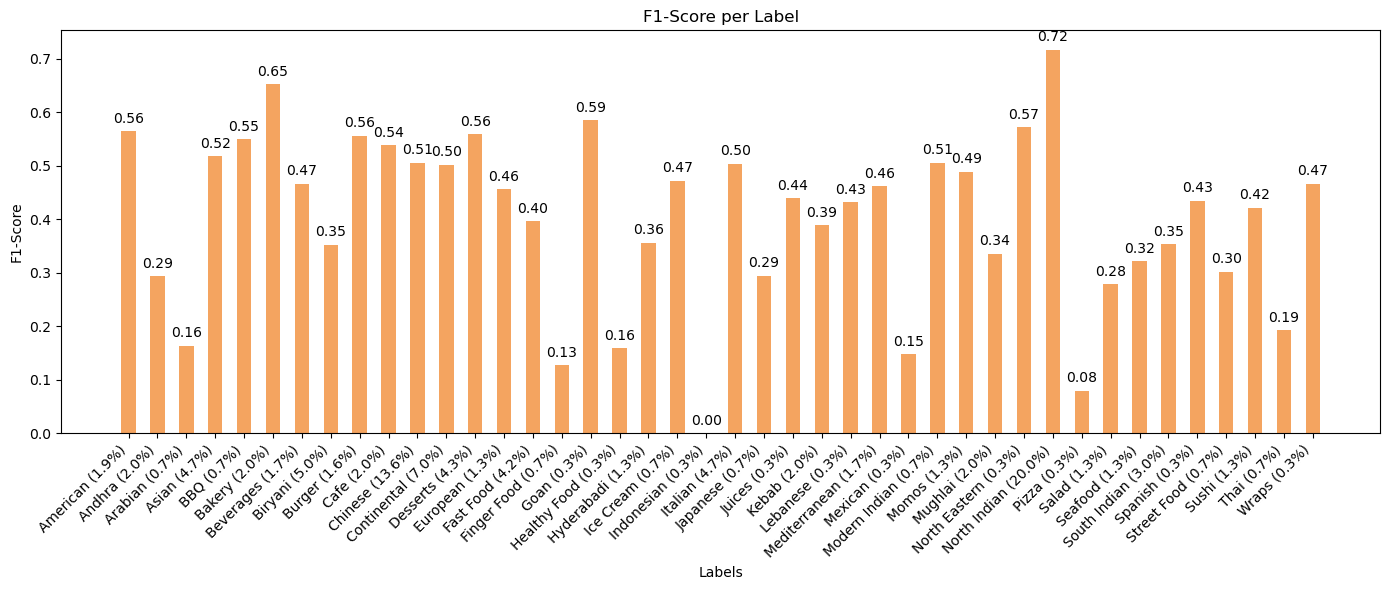

In [18]:
# Generate classification report
report = classification_report(y_test_q1, y_pred_q1_test, target_names=mlb.classes_, output_dict=True)

# Extract F1-scores
labels = mlb.classes_
f1_scores = [report[label]['f1-score'] for label in labels]

# Calculate the percentage of the dataset that each label represents
label_counts = np.sum(y_test_q1, axis=0)
total_count = np.sum(label_counts)
label_percentages = (label_counts / total_count) * 100

# Create labels with percentages
labels_with_percentages = [f"{label} ({percentage:.1f}%)" for label, percentage in zip(labels, label_percentages)]

# Plot F1-scores
plt.figure(figsize=(14, 6))  
bar_width = 0.6  # Set the width of the bars
bar_positions = np.arange(len(labels_with_percentages)) * 1.2  #  add spacing

plt.bar(bar_positions, f1_scores, width=bar_width, color='sandybrown')
plt.xlabel('Labels')
plt.ylabel('F1-Score')
plt.title('F1-Score per Label')
plt.xticks(bar_positions, labels_with_percentages, rotation=45, ha="right")

# Add values on top of bars
for i, score in enumerate(f1_scores):
    plt.text(bar_positions[i], score + 0.01, f'{score:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

We observe in this chart that cuisines with fewer data points generally tend to have lower F1 scores. 

This trend is evident in categories such as Pizza, Mexican, and Ice Cream, which have relatively low scores. This contributed to the overall decrease in the F1 score.

In [24]:
report = classification_report(y_test_q1, y_pred_q1_test, target_names=mlb.classes_)

print("Classification Report:")
print(report)

Classification Report:
               precision    recall  f1-score   support

     American       0.56      0.52      0.54       115
       Andhra       0.56      0.23      0.33       118
      Arabian       0.33      0.15      0.21        40
        Asian       0.50      0.49      0.50       280
          BBQ       0.25      0.62      0.35        40
       Bakery       0.57      0.57      0.57       120
    Beverages       0.41      0.50      0.45       100
      Biryani       0.58      0.25      0.35       297
       Burger       0.48      0.55      0.51        95
         Cafe       0.69      0.55      0.61       120
      Chinese       0.65      0.46      0.54       816
  Continental       0.62      0.51      0.56       417
     Desserts       0.66      0.48      0.56       260
     European       0.58      0.54      0.56        80
    Fast Food       0.29      0.66      0.40       254
  Finger Food       0.35      0.15      0.21        40
         Goan       0.65      0.55      0

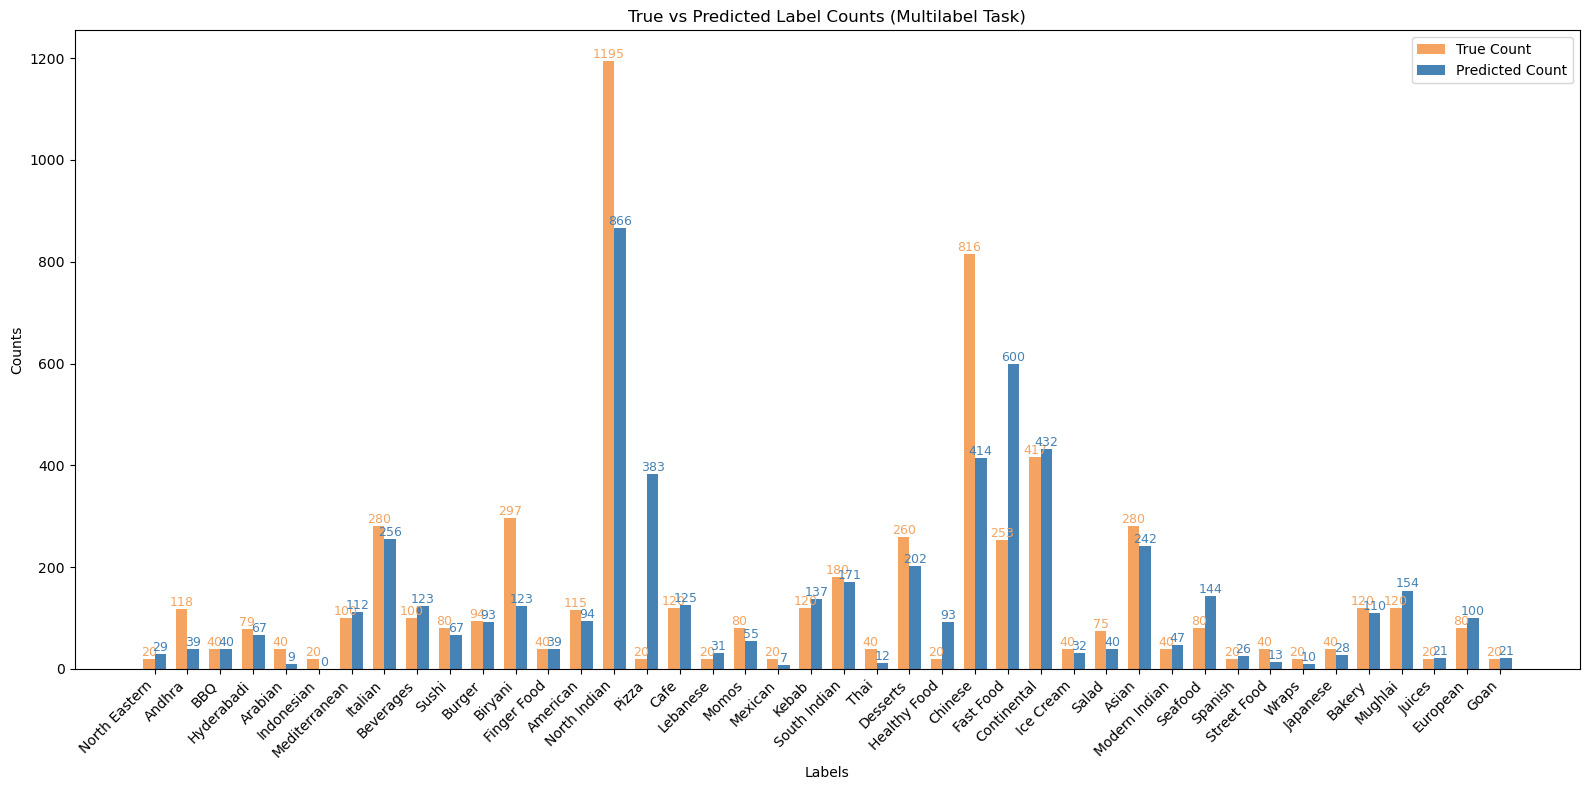

In [20]:
# Convert binary matrices back to label lists
y_test_q1_inverse = mlb.inverse_transform(y_test_q1)
y_pred_q1_test_inverse = mlb.inverse_transform(y_pred_q1_test)

# Flatten the lists of labels 
flattened_labels_test = [label for sublist in y_test_q1_inverse for label in sublist]
flattened_labels_pred = [label for sublist in y_pred_q1_test_inverse for label in sublist]

# Count the occurrences of each label
label_counts_test = Counter(flattened_labels_test)
label_counts_pred = Counter(flattened_labels_pred)

# Combine label counts for both true and predicted labels
all_labels = list(set(label_counts_test.keys()).union(set(label_counts_pred.keys())))

# Prepare data for plotting
true_counts = [label_counts_test.get(label, 0) for label in all_labels]
pred_counts = [label_counts_pred.get(label, 0) for label in all_labels]


plt.figure(figsize=(16, 8))
x = np.arange(len(all_labels))
bar_width = 0.35
plt.bar(x - bar_width / 2, true_counts, width=bar_width, color='sandybrown', label='True Count')
plt.bar(x + bar_width / 2, pred_counts, width=bar_width, color='steelblue', label='Predicted Count')
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('True vs Predicted Label Counts (Multilabel Task)')
plt.xticks(x, all_labels, rotation=45, ha="right")
plt.legend()

# Add values on top of bars
for i in range(len(all_labels)):
    plt.text(x[i] - bar_width / 2, true_counts[i] + 0.01, f'{true_counts[i]}', ha='center', va='bottom', color='sandybrown', fontsize=9)
    plt.text(x[i] + bar_width / 2, pred_counts[i] + 0.01, f'{pred_counts[i]}', ha='center', va='bottom', color='steelblue', fontsize=9)


plt.tight_layout()
plt.show()

It is possible to observe that some classes are overpredicted, while others are underpredicted. Cuisines such as Chinese and North Indian are being underpredicted, whereas minority classes like Pizza and Fast Food are being overpredicted. 

This is likely due to the challenges of stratifying the data in a way that ensures equal representation of all cuisines in both the training and test sets.

As a result, these cuisines may be more heavily represented in the training data, leading to these imbalances in predictions